In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

In [3]:
import time
from itertools import chain
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad, tree_map
import jaxlib
import jax
import pandas as pd
import optax
from itertools import chain

import jaxley as jx
from jaxley.optimize.utils import l2_norm
from jaxley.channels import Leak
from nex.l5pc.utils.modified_channels import *
from jaxley.optimize.utils import l2_norm

/var/folders/kv/39t9blx569l5_sxxzx89vb3c0000gn/T/ipykernel_36424/1921340280.py:9: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  from jax import jit, vmap, value_and_grad, tree_map


In [4]:
print(f"jax {jax.__version__}")
print(f"jaxlib {jaxlib.__version__}")
print(f"pandas {pd.__version__}")
print(f"optax {optax.__version__}")
print(f"numpy {np.__version__}")

jax 0.4.29
jaxlib 0.4.28
pandas 2.2.1
optax 0.2.2
numpy 1.26.4


In [5]:
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [6]:
def sample_within(n, bounds):
    return jnp.asarray(np.random.rand(n) * (bounds[1] - bounds[0]) + bounds[0])

In [7]:
bounds = {}
gt_apical = {}
gt_soma = {}
gt_axon = {}

bounds["somatic_NaTs2T_gNaTs2T"] = [0.0, 2.0]
gt_soma["somatic_NaTs2T_gNaTs2T"] = 0.983955

bounds["somatic_SKv3_1_gSKv3_1"] = [0.25, 1]
gt_soma["somatic_SKv3_1_gSKv3_1"] = 0.303472

bounds["somatic_SKE2_gSKE2"] = [0, 0.1]
gt_soma["somatic_SKE2_gSKE2"] = 0.008407

bounds["somatic_CaHVA_gCaHVA"] = [0, 0.001]
gt_soma["somatic_CaHVA_gCaHVA"] = 0.000994

bounds["somatic_CaLVA_gCaLVA"] = [0, 0.01]
gt_soma["somatic_CaLVA_gCaLVA"] = 0.000333

bounds["apical_NaTs2T_gNaTs2T"] = [0, 0.04]
gt_apical["apical_NaTs2T_gNaTs2T"] = 0.026145

bounds["apical_SKv3_1_gSKv3_1"] = [0, 0.04]
gt_apical["apical_SKv3_1_gSKv3_1"] = 0.004226

bounds["apical_M_gM"] = [0, 0.001]
gt_apical["apical_M_gM"] = 0.000143

bounds["somatic_CaPump_gamma"] = [0.0005,0.01]
gt_soma["somatic_CaPump_gamma"] = 0.000609

bounds["somatic_CaPump_decay"] = [10, 1_000]
gt_soma["somatic_CaPump_decay"] = 210.485291

bounds["axonal_NaTaT_gNaTaT"] = [0.0, 4.0]
gt_axon["axonal_NaTaT_gNaTaT"] = 3.137968

bounds["axonal_KPst_gKPst"] = [0.0, 1.0]
gt_axon["axonal_KPst_gKPst"] = 0.973538

bounds["axonal_KTst_gKTst"] = [0.0, 0.1]
gt_axon["axonal_KTst_gKTst"] = 0.089259

bounds["axonal_SKE2_gSKE2"] = [0.0, 0.1]
gt_axon["axonal_SKE2_gSKE2"] = 0.007104

bounds["axonal_SKv3_1_gSKv3_1"] = [0.0, 2.0]  # [0, 2.0]
gt_axon["axonal_SKv3_1_gSKv3_1"] = 1.021945

bounds["axonal_CaHVA_gCaHVA"] = [0, 0.001]  # 0.001
gt_axon["axonal_CaHVA_gCaHVA"] = 0.00099

bounds["axonal_CaLVA_gCaLVA"] = [0, 0.01]  # 0.01
gt_axon["axonal_CaLVA_gCaLVA"] = 0.008752

bounds["axonal_CaPump_gamma"] = [0.0005, 0.05]  # [0.0005,0.05]
gt_axon["axonal_CaPump_gamma"] = 0.00291

bounds["axonal_CaPump_decay"] = [10, 1_000]
gt_axon["axonal_CaPump_decay"] = 287.19873

In [8]:
# Working: "485574832", "488683425", "473601979", 
setup = "485574832"
use_spatial_profile = False
dt = 0.025

if setup == "488683425":
    swc_fname = "../../../nex/l5pc/cell_types/specimen_488683425/reconstruction.swc"
    rotation = 195
    i_amp = None
    i_delay = 50.0
    v_init = -83.15625
    spike_window_start = 70.0
    gleak = 5e-5
    capacitance = 2.0
    eleak = -88.0
elif setup == "485574832":
    swc_fname = "../../../nex/l5pc/cell_types/specimen_485574832/reconstruction.swc"
    rotation = 155
    i_amp = None
    i_delay = 50.0
    v_init = -85.6
    spike_window_start = 70.0
    gleak = 1e-4
    capacitance = 4.0
    eleak = -88.0
elif setup == "480353286":
    swc_fname = "../../../nex/l5pc/cell_types/specimen_480353286/reconstruction.swc"
    rotation = 170
    i_amp = None
    i_delay = 50.0
    v_init = -88.90625
    spike_window_start = 74.0
    gleak = 1e-4
    capacitance = 3.0
    eleak = -95.0
elif setup == "473601979":
    swc_fname = "../../../nex/l5pc/cell_types/specimen_473601979/reconstruction.swc"
    rotation = 195
    i_amp = None
    i_delay = 50.0
    v_init = -89.06251
    spike_window_start = 57.0
    gleak = 1e-4
    capacitance = 2.0  # 2.0 worked well
    eleak = -88.0  # -88.0 worked well
elif setup == "480351780":
    swc_fname = "../../../nex/l5pc/cell_types/specimen_480351780/reconstruction.swc"
    rotation = 0
    i_amp = None
    i_delay = 50.0
    v_init = -120.0
    spike_window_start = 10.0
    gleak = 1e-4
    capacitance = 1.0
    eleak = -95.0
    raise ValueError("This morphology does not have a traced axon")
elif setup == "484559000":
    swc_fname = "../../../nex/l5pc/cell_types/specimen_484559000/reconstruction.swc"
    rotation = 0
    i_amp = None
    i_delay = 50.0
    v_init = -120.0
    spike_window_start = 10.0
    gleak = 1e-4
    capacitance = 1.0
    eleak = -95.0
    raise ValueError("This morphology does not have a traced axon")
else:
    raise NotImplementedError

In [9]:
def read_cell(nseg):
    cell = jx.read_swc(swc_fname, nseg=nseg, max_branch_len=300.0, assign_groups=True)
    cell.rotate(rotation)
    return cell

/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:32: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


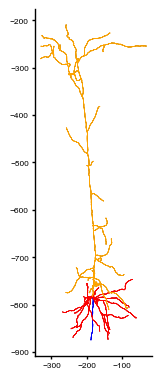

In [10]:
cell = read_cell(nseg=4)

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.5, 4.5))
    ax = cell.vis(ax=ax, morph_plot_kwargs={"linewidth": 0.2})
    ax = cell.axon.vis(ax=ax, morph_plot_kwargs={"linewidth": 0.5}, col="b")
    ax = cell.basal.vis(ax=ax, morph_plot_kwargs={"linewidth": 0.5}, col="r")
    ax = cell.apical.vis(ax=ax, morph_plot_kwargs={"linewidth": 0.5}, col="orange")
    plt.show()
    
soma_inds = np.unique(cell.group_nodes["soma"].branch_index).tolist()
apical_inds = np.unique(cell.group_nodes["apical"].branch_index).tolist()
basal_inds = np.unique(cell.group_nodes["basal"].branch_index).tolist()
axon_inds = np.unique(cell.group_nodes["axon"].branch_index).tolist()

group_inds = {
    "soma": soma_inds,
    "apical": apical_inds,
    "basal": basal_inds,
    "axon": axon_inds,
}

### Build cell

In [11]:
nseg = 4

########## APICAL ##########
cell.apical.set("capacitance", 2.0)
cell.apical.insert(Leak().change_name("apical_Leak"))
cell.apical.insert(NaTs2T().change_name("apical_NaTs2T"))
cell.apical.insert(SKv3_1().change_name("apical_SKv3_1"))
cell.apical.insert(M().change_name("apical_M"))
cell.apical.insert(H().change_name("apical_H"))
for b in apical_inds:
    for c in range(4):
        distance = cell.branch(b).comp(c).distance(cell.branch(soma_inds[0]).loc(0.5))
        cond = (-0.8696 + 2.087* np.exp(distance*0.0031)) * 8e-5
        cell.branch(b).comp(c).set("apical_H_gH", cond)

########## SOMA ##########
cell.soma.insert(Leak().change_name("somatic_Leak"))
cell.soma.insert(NaTs2T().change_name("somatic_NaTs2T"))
cell.soma.insert(SKv3_1().change_name("somatic_SKv3_1"))
cell.soma.insert(SKE2().change_name("somatic_SKE2"))
ca_dynamics = CaNernstReversal()
ca_dynamics.channel_constants["T"] = 307.15
cell.soma.insert(ca_dynamics)
cell.soma.insert(CaPump().change_name("somatic_CaPump"))
cell.soma.insert(CaHVA().change_name("somatic_CaHVA"))
cell.soma.insert(CaLVA().change_name("somatic_CaLVA"))
cell.soma.set("CaCon_i", 5e-05)
cell.soma.set("CaCon_e", 2.0)

########## BASAL ##########
cell.basal.insert(Leak().change_name("basal_Leak"))
cell.basal.insert(H().change_name("basal_H"))
cell.basal.set("basal_H_gH", 8e-5)

# ########## AXON ##########
cell.axon.insert(Leak().change_name("axonal_Leak"))
cell.axon.insert(NaTaT().change_name("axonal_NaTaT"))
cell.axon.insert(KPst().change_name("axonal_KPst"))
cell.axon.insert(KTst().change_name("axonal_KTst"))
cell.axon.insert(SKE2().change_name("axonal_SKE2"))
cell.axon.insert(SKv3_1().change_name("axonal_SKv3_1"))
ca_dynamics_axonal = CaNernstReversal()
ca_dynamics_axonal.channel_constants["T"] = 307.15
cell.axon.insert(ca_dynamics)
cell.set("CaCon_i", 5e-05)
cell.set("CaCon_e", 2.0)
cell.axon.insert(CaHVA().change_name("axonal_CaHVA"))
cell.axon.insert(CaLVA().change_name("axonal_CaLVA"))
cell.axon.insert(CaPump().change_name("axonal_CaPump"))

########## WHOLE CELL  ##########
cell.set("axial_resistivity", 100.0)

cell.set("capacitance", capacitance)
# cell.insert(Leak())
# cell.set("Leak_eLeak", eleak)
# cell.set("Leak_gLeak", gleak)

cell.set("apical_Leak_eLeak", eleak)
cell.set("somatic_Leak_eLeak", eleak)
cell.set("basal_Leak_eLeak", eleak)
cell.set("axonal_Leak_eLeak", eleak)

cell.set("apical_Leak_gLeak", gleak)
cell.set("somatic_Leak_gLeak", gleak)
cell.set("basal_Leak_gLeak", gleak)
cell.set("axonal_Leak_gLeak", gleak)

cell.set("vt", 0.0)
cell.set("eK", -70.0)
cell.set("eNa", 50.0)
cell.set("HVA_tau", 1.0)
cell.set("LVA_tau", 1.0)

In [12]:
def set_all_branches(params):
    """
    Args:
        params: Should have shape `(10,)`.
    """
    pstate = None
    names = list(bounds.keys())

    for counter in range(5):
        key = names[counter]
        p = params[counter]
        pstate = cell.soma.data_set(key, p, pstate)

    for counter in range(5, 8):
        key = names[counter]
        p = params[counter]
        pstate = cell.apical.data_set(key, params[counter], pstate)
    
    for counter in range(8, 10):
        key = names[counter]
        p = params[counter]
        pstate = cell.soma.data_set(key, p, pstate)
        
    for counter in range(10, 19):
        key = names[counter]
        p = params[counter]
        pstate = cell.axon.data_set(key, p, pstate)

    assert counter == 18
    return pstate

### Load experimental x_o

In [13]:
with open(f"../../../nex/l5pc/cell_types/specimen_{setup}/ephys_01.pkl", "rb") as handle:
    ephys = pickle.load(handle)

dt_stim = np.mean(np.diff(ephys["time"]))
dt_difference = dt / dt_stim / 1000
print("dt_difference", dt_difference)
junction_potential = -14.0

ephys_stim = ephys["stimulus"][::int(dt_difference)]
ephys_rec = ephys["response"][::int(dt_difference)] + junction_potential
ephys_time_vec = ephys["time"][::int(dt_difference)]

time_pad_on = 50.0
time_pad_off = 150.0

stim_onset = np.where(ephys_stim > 0.05)[0][0]
protocol_start = int(stim_onset - time_pad_on / 0.025)

stim_offset = np.where(ephys_stim < 0.05)[0]
stim_offset = stim_offset[stim_offset > 20_000][0]
protocol_end = int(stim_offset + time_pad_off / 0.025)

ephys_stim = ephys_stim[protocol_start:protocol_end]
ephys_rec = ephys_rec[protocol_start:protocol_end]
ephys_time_vec = ephys_time_vec[protocol_start:protocol_end] * 1000
ephys_time_vec -= ephys_time_vec[0]

if i_amp is None:
    i_amp = np.max(ephys_stim)
    print(f"Amplitude: {i_amp}")

    

dt_difference 5.0
Amplitude: 0.33000001311302185


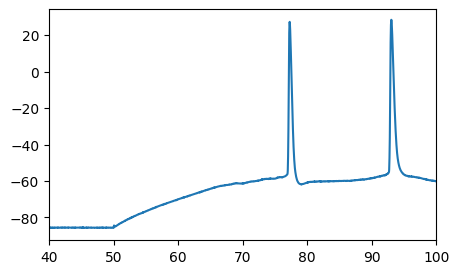

In [14]:

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(ephys_time_vec, ephys_rec)
ax.set_xlim([40, 100])
plt.show()

### Define summary stats

In [15]:
def simulate(params):
    parameters = set_all_branches(params)
    return jx.integrate(cell, param_state=parameters, checkpoint_lengths=cp)

jitted_sim = jit(simulate)
vmapped_sim = jit(vmap(simulate, in_axes=(0,)))

In [16]:
def summary_stats(v):
    max1 = jnp.max(v[:, window1])
    max2 = jnp.max(v[:, window2])
    mean3 = jnp.mean(v[:, window3])
    std3 = jnp.std(v[:, window3])
    max3 = jnp.max(v[:, window3])
    mean4 = jnp.mean(v[:, window4])
    std4 = jnp.std(v[:, window4])
    return jnp.asarray([max1, max2, mean3, std3, mean4, std4])

vmapped_summary_stats = vmap(summary_stats, in_axes=(0,))


def loss_from_v(v):
    ss = summary_stats(v)
    return jnp.sum(jnp.abs((ss - x_o_ss) / z_score_factors), axis=0)

vmapped_loss_from_v = vmap(loss_from_v, in_axes=(0,))


def loss_fn(opt_params):
    params = transform.forward(opt_params)
    vals = [list(p.values())[0] for p in params]
    vs = simulate(vals)
    loss = loss_from_v(vs)
    return loss

jitted_loss_fn = jit(loss_fn)
grad_fn = jit(value_and_grad(loss_fn))


def init():
    param_set = []
    for key in bounds:
        if key == "axonal_CaPump_decay" or key == "somatic_CaPump_decay":
            # Log-uniform for pump decays.
            low = np.log(bounds[key][0])
            high = np.log(bounds[key][1])
            samples = np.exp(np.random.uniform(low, high, (1,)))
        else:
            samples = sample_within(1, bounds[key]).tolist()
        param_set.append({key: jnp.asarray(samples)})
    return param_set


transform = jx.ParamTransform(
    lowers={
        "somatic_NaTs2T_gNaTs2T": 0.0,
        "somatic_SKv3_1_gSKv3_1": 0.25,
        "somatic_SKE2_gSKE2": 0.0,
        "somatic_CaHVA_gCaHVA": 0.0,
        "somatic_CaLVA_gCaLVA": 0.0,
        "apical_NaTs2T_gNaTs2T": 0.0,
        "apical_SKv3_1_gSKv3_1": 0.0,
        "apical_M_gM": 0.0,
        "somatic_CaPump_gamma": 0.0005,
        "somatic_CaPump_decay": 10,
        "axonal_NaTaT_gNaTaT": 0.0,
        "axonal_KPst_gKPst": 0.0,
        "axonal_KTst_gKTst": 0.0,
        "axonal_SKE2_gSKE2": 0.0,
        "axonal_SKv3_1_gSKv3_1": 0.0,
        "axonal_CaHVA_gCaHVA": 0,
        "axonal_CaLVA_gCaLVA": 0,
        "axonal_CaPump_gamma": 0.0005,
        "axonal_CaPump_decay": 10,
    },
    uppers={
        "somatic_NaTs2T_gNaTs2T": 2.0,
        "somatic_SKv3_1_gSKv3_1": 1.0,
        "somatic_SKE2_gSKE2": 0.1,
        "somatic_CaHVA_gCaHVA": 0.001,
        "somatic_CaLVA_gCaLVA": 0.01,
        "apical_NaTs2T_gNaTs2T": 0.04,
        "apical_SKv3_1_gSKv3_1": 0.04,
        "apical_M_gM": 0.001,
        "somatic_CaPump_gamma": 0.01,
        "somatic_CaPump_decay": 1_000,
        "axonal_NaTaT_gNaTaT": 4.0,
        "axonal_KPst_gKPst": 1.0,
        "axonal_KTst_gKTst": 0.1,
        "axonal_SKE2_gSKE2": 0.1,
        "axonal_SKv3_1_gSKv3_1": 2.0,
        "axonal_CaHVA_gCaHVA": 0.001,
        "axonal_CaLVA_gCaLVA": 0.01,
        "axonal_CaPump_gamma": 0.05,
        "axonal_CaPump_decay": 1_000,
    },
)

# Gradient descent

In [17]:
# Define time.
t_max = 1150.0
required_loss = 1.0
i_dur = np.maximum(250.0, t_max - i_delay)
i_dur = 1000.0
time_vec = np.arange(0, t_max+2*dt, dt)
cp = [int(np.ceil(np.sqrt(len(time_vec))).item()) for _ in range(2)]
z_score_factors = np.asarray([50.0, 50.0, 10.0, 5.0, 10.0, 5.0])

window1 = np.logical_and(time_vec > 50.0, time_vec < spike_window_start)
window2 = np.logical_and(time_vec > spike_window_start, time_vec < spike_window_start + 15.0)
window3 = np.logical_and(time_vec > spike_window_start + 10.0, time_vec < 140.0)
window4 = np.logical_and(time_vec > 140.0, time_vec < 1050.0)
windows = [window1, window2, window3, window4]

ephys_rec_for_ss = ephys_rec[:len(time_vec)][None, :]
ephys_initial_voltage = ephys_rec_for_ss[0,0]
print("ephys_initial_voltage", ephys_initial_voltage)

# Build cell with approriate stimuli.
cell.delete_stimuli()
cell.delete_recordings()

current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)

cell.soma[0,0].stimulate(current)  # Stimulate soma
cell.soma[0,0].record()
cell.set("v", v_init)
cell.init_states()

x_o_ss = summary_stats(ephys_rec_for_ss)
print(f"Observed summary stats: {x_o_ss}")
z_score_factors = z_score_factors[:len(x_o_ss)]


ephys_initial_voltage -85.59376
Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.
Observed summary stats: [-61.187504  27.3125   -58.8713    11.124269 -59.336468   9.418617]


loss in epoch 0: 2.3502, gradient_norm 1.2618, corrected 1.0476
loss in epoch 1: 0.7570, gradient_norm 0.1933, corrected 0.7199
loss in epoch 2: 0.7922, gradient_norm 1.0256, corrected 1.0051
loss in epoch 3: 0.7456, gradient_norm 0.5083, corrected 0.8734
loss in epoch 4: 0.7043, gradient_norm 1.7793, corrected 1.1221
loss in epoch 5: 0.7434, gradient_norm 0.8924, corrected 0.9775
loss in epoch 6: 0.8075, gradient_norm 0.4807, corrected 0.8637
loss in epoch 7: 0.6750, gradient_norm 0.8484, corrected 0.9677
loss in epoch 8: 0.7391, gradient_norm 0.5287, corrected 0.8803
loss in epoch 9: 0.8450, gradient_norm 0.4018, corrected 0.8333


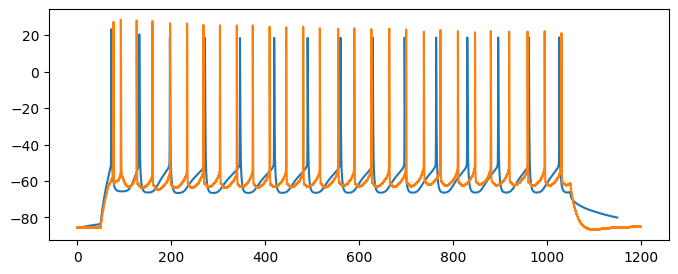

===== Best loss 0.6749950663304491 =====
loss in epoch 0: 1.2629, gradient_norm 2.1501, corrected 1.1654
loss in epoch 1: 1.2750, gradient_norm 0.9206, corrected 0.9836
loss in epoch 2: 1.2523, gradient_norm 0.1099, corrected 0.6430
loss in epoch 3: 1.1759, gradient_norm 0.4064, corrected 0.8352
loss in epoch 4: 1.1523, gradient_norm 0.5947, corrected 0.9013
loss in epoch 5: 1.0843, gradient_norm 6.5497, corrected 1.4563
loss in epoch 6: 2.0908, gradient_norm 1.8073, corrected 1.1257
loss in epoch 7: 1.1727, gradient_norm 0.9916, corrected 0.9983
loss in epoch 8: 1.1805, gradient_norm 1.2694, corrected 1.0489
loss in epoch 9: 1.1425, gradient_norm 0.1497, corrected 0.6840


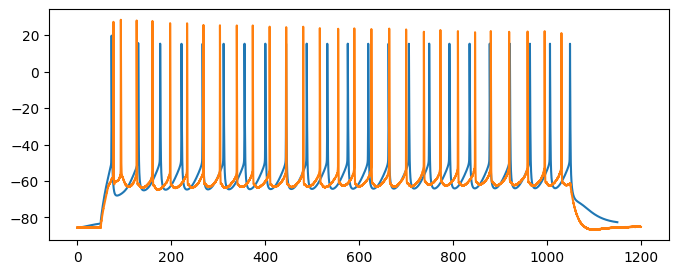

===== Best loss 1.084302507223862 =====
loss in epoch 0: 3.7553, gradient_norm 0.9639, corrected 0.9927
loss in epoch 1: 3.9580, gradient_norm 0.2865, corrected 0.7788
loss in epoch 2: 4.0572, gradient_norm 0.5899, corrected 0.8998
loss in epoch 3: 4.0989, gradient_norm 0.6270, corrected 0.9109
loss in epoch 4: 4.4306, gradient_norm 0.2664, corrected 0.7675
loss in epoch 5: 4.8626, gradient_norm 1.4278, corrected 1.0738
loss in epoch 6: 3.8258, gradient_norm 1.2585, corrected 1.0471
loss in epoch 7: 1.1903, gradient_norm 1.3295, corrected 1.0586
loss in epoch 8: 2.5556, gradient_norm 1.4528, corrected 1.0776
loss in epoch 9: 1.1889, gradient_norm 0.6297, corrected 0.9116


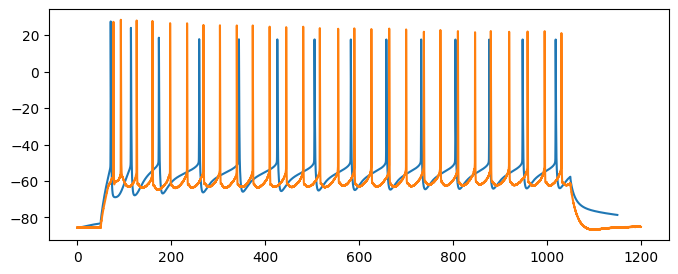

===== Best loss 1.188940459141345 =====
loss in epoch 0: 3.8738, gradient_norm 1.5603, corrected 1.0930
loss in epoch 1: 1.6353, gradient_norm 0.9762, corrected 0.9952
loss in epoch 2: 1.2848, gradient_norm 0.4238, corrected 0.8422
loss in epoch 3: 1.2812, gradient_norm 0.2872, corrected 0.7792
loss in epoch 4: 1.2065, gradient_norm 0.4386, corrected 0.8480
loss in epoch 5: 1.1006, gradient_norm 0.2412, corrected 0.7524
loss in epoch 6: 1.0950, gradient_norm 0.3662, corrected 0.8180
loss in epoch 7: 1.1487, gradient_norm 0.2301, corrected 0.7454
loss in epoch 8: 1.1888, gradient_norm 0.2684, corrected 0.7687
loss in epoch 9: 1.3111, gradient_norm 0.5411, corrected 0.8844


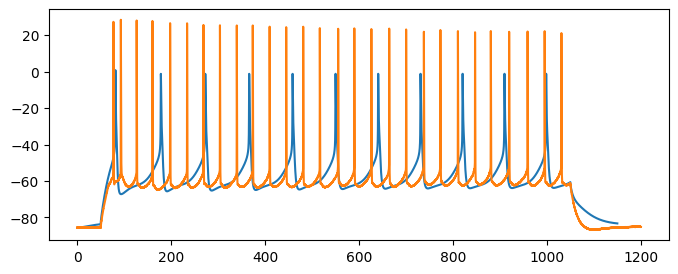

===== Best loss 1.0949827366255587 =====
loss in epoch 0: 2.0153, gradient_norm 0.5990, corrected 0.9026
loss in epoch 1: 1.6662, gradient_norm 0.6597, corrected 0.9202
loss in epoch 2: 1.4819, gradient_norm 0.5578, corrected 0.8898
loss in epoch 3: 1.4545, gradient_norm 0.5666, corrected 0.8926
loss in epoch 4: 1.5748, gradient_norm 1.6110, corrected 1.1001
loss in epoch 5: 1.5004, gradient_norm 0.5145, corrected 0.8756
loss in epoch 6: 1.3802, gradient_norm 0.4347, corrected 0.8465
loss in epoch 7: 1.4288, gradient_norm 0.4489, corrected 0.8520
loss in epoch 8: 1.3606, gradient_norm 0.4010, corrected 0.8330
loss in epoch 9: 1.4081, gradient_norm 0.5426, corrected 0.8849


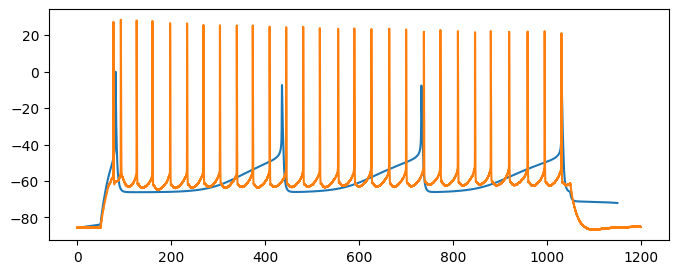

===== Best loss 1.3605853085060007 =====
loss in epoch 0: 3.9782, gradient_norm 4.2780, corrected 1.3374
loss in epoch 1: 3.4623, gradient_norm 1.5090, corrected 1.0858
loss in epoch 2: 1.8763, gradient_norm 0.4102, corrected 0.8368
loss in epoch 3: 1.9937, gradient_norm 0.7387, corrected 0.9412
loss in epoch 4: 1.6096, gradient_norm 1.2175, corrected 1.0401
loss in epoch 5: 2.2528, gradient_norm 2.1302, corrected 1.1633
loss in epoch 6: 1.9209, gradient_norm 2.2585, corrected 1.1770
loss in epoch 7: 1.8109, gradient_norm 0.3125, corrected 0.7925
loss in epoch 8: 2.4131, gradient_norm 0.4866, corrected 0.8658
loss in epoch 9: 3.7499, gradient_norm 4.3987, corrected 1.3448


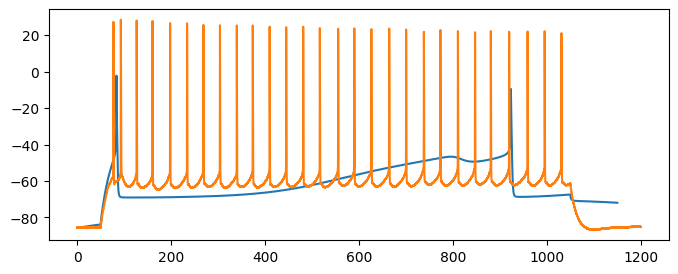

===== Best loss 1.6096190489044133 =====
loss in epoch 0: 1.2284, gradient_norm 1.2779, corrected 1.0503
loss in epoch 1: 2.2882, gradient_norm 1.7081, corrected 1.1130
loss in epoch 2: 1.1654, gradient_norm 0.3018, corrected 0.7869
loss in epoch 3: 1.1053, gradient_norm 0.3994, corrected 0.8323
loss in epoch 4: 1.1412, gradient_norm 1.9270, corrected 1.1402
loss in epoch 5: 1.0011, gradient_norm 0.5796, corrected 0.8967
loss in epoch 6: 1.0360, gradient_norm 0.3785, corrected 0.8234
loss in epoch 7: 1.1046, gradient_norm 0.8119, corrected 0.9592
loss in epoch 8: 1.0690, gradient_norm 0.1495, corrected 0.6838
loss in epoch 9: 1.0535, gradient_norm 4.0239, corrected 1.3211


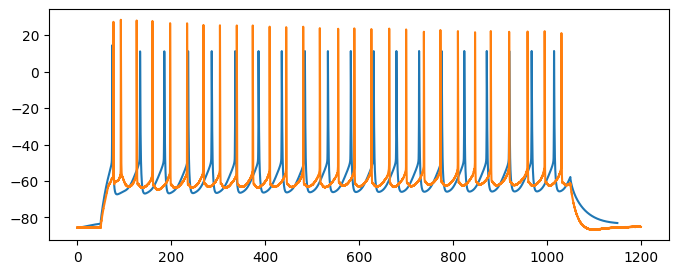

===== Best loss 1.0010985578039195 =====
loss in epoch 0: 2.0312, gradient_norm 2.5263, corrected 1.2036
loss in epoch 1: 1.7381, gradient_norm 1.4056, corrected 1.0705
loss in epoch 2: 1.5995, gradient_norm 0.7604, corrected 0.9467
loss in epoch 3: 1.4797, gradient_norm 0.4504, corrected 0.8525
loss in epoch 4: 1.5828, gradient_norm 0.1707, corrected 0.7022
loss in epoch 5: 1.4969, gradient_norm 0.6165, corrected 0.9078
loss in epoch 6: 1.4552, gradient_norm 0.7362, corrected 0.9406
loss in epoch 7: 1.6257, gradient_norm 0.7318, corrected 0.9395
loss in epoch 8: 1.4273, gradient_norm 0.7744, corrected 0.9501
loss in epoch 9: 1.5145, gradient_norm 0.4064, corrected 0.8352


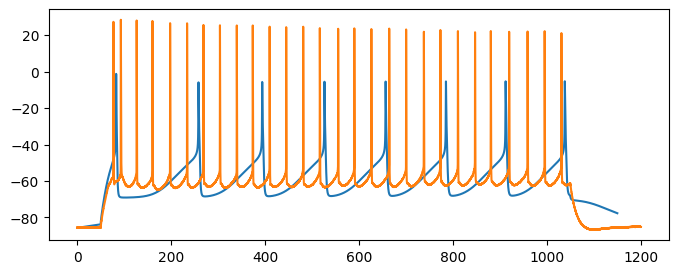

===== Best loss 1.42728187537934 =====
loss in epoch 0: 1.3127, gradient_norm 0.4315, corrected 0.8453
loss in epoch 1: 1.2744, gradient_norm 0.2778, corrected 0.7740
loss in epoch 2: 1.2674, gradient_norm 0.1728, corrected 0.7039
loss in epoch 3: 1.2174, gradient_norm 0.2981, corrected 0.7850
loss in epoch 4: 1.2202, gradient_norm 0.6036, corrected 0.9040
loss in epoch 5: 1.2720, gradient_norm 0.3141, corrected 0.7932
loss in epoch 6: 1.1958, gradient_norm 0.1850, corrected 0.7136
loss in epoch 7: 1.1771, gradient_norm 0.1816, corrected 0.7109
loss in epoch 8: 1.2433, gradient_norm 0.1766, corrected 0.7070
loss in epoch 9: 1.2933, gradient_norm 0.2289, corrected 0.7446


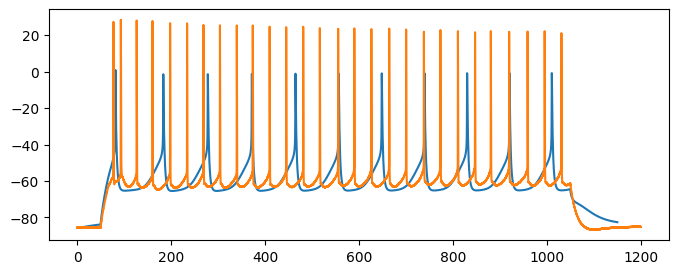

===== Best loss 1.17709329686361 =====
loss in epoch 0: 3.4359, gradient_norm 1.2692, corrected 1.0488
loss in epoch 1: 1.2297, gradient_norm 0.8138, corrected 0.9596
loss in epoch 2: 1.2214, gradient_norm 15.9620, corrected 1.7403
loss in epoch 3: 3.1651, gradient_norm 4.1054, corrected 1.3264
loss in epoch 4: 1.3746, gradient_norm 0.4217, corrected 0.8414
loss in epoch 5: 1.3316, gradient_norm 0.3257, corrected 0.7991
loss in epoch 6: 1.1734, gradient_norm 0.5322, corrected 0.8815
loss in epoch 7: 1.1975, gradient_norm 0.5179, corrected 0.8767
loss in epoch 8: 1.0302, gradient_norm 0.1844, corrected 0.7131
loss in epoch 9: 1.0310, gradient_norm 0.6253, corrected 0.9104


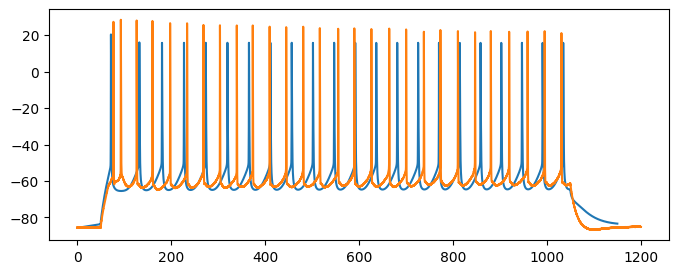

===== Best loss 1.0302098991213027 =====
gradient_descent_total_time 1332.0041480064392


In [18]:
num_particles = 10
num_inits = 5

_ = np.random.seed(42)
all_opt_params = []
for i in range(num_particles):
    all_current = []
    all_losses = []
    for k in range(num_inits):
        opt_params = transform.inverse(init())
        all_current.append(opt_params)
        all_losses.append(jitted_loss_fn(opt_params))
    best_loss_ind = np.argmin(np.asarray(all_losses))
    best_opt_params = all_current[best_loss_ind]
    all_opt_params.append(best_opt_params) # transform.inverse(init()))

losses_of_every_starting_point = []
best_traces = []
best_losses = []
all_best_params = []
total_sims = 0
# beta=0 -> gradient descent
# 0<beta<1 -> gradient is not fully normalized, but tends to be more equally long
# beta=1 -> GD where the gradient is normalized to unit lenght
# beta>1 -> larger gradients lead to smaller stepsizes
beta = 0.8

start_time = time.time()
for opt_params in all_opt_params:    
    train_losses = []
    
    best_loss = 100.0
    required_loss = 0.9

    optimizer = optax.inject_hyperparams(optax.sgd)(learning_rate=3.0)
    opt_state = optimizer.init(opt_params)
    for epoch in range(10):
        loss_val, grad_val = grad_fn(opt_params)
        total_sims += 1

        grad_norm = l2_norm(grad_val)
        grad_val = tree_map(lambda x: x / grad_norm**beta, grad_val) 
        print(f"loss in epoch {epoch}: {loss_val:.4f}, gradient_norm {grad_norm:.4f}, corrected {l2_norm(grad_val):.4f}")
        train_losses.append(loss_val)

        # Convergence checks.
        if loss_val < best_loss:
            best_loss = loss_val
            best_params = deepcopy(opt_params)

        # Optimizer step.
        opt_state.hyperparams['learning_rate'] = loss_val / 3.0  # Polyak style learning rate.
        updates, opt_state = optimizer.update(grad_val, opt_state)
        update_norm = l2_norm(updates)
        opt_params = optax.apply_updates(opt_params, updates)

    params = transform.forward(best_params)
    vals = [list(p.values())[0] for p in params]
    best_trace = jitted_sim(vals)
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    _ = ax.plot(time_vec, best_trace.T)
    _ = ax.plot(ephys_time_vec, ephys_rec)
    plt.show()

    if best_loss < 1.7:
        best_traces.append(best_trace)
        best_losses.append(best_loss)
        all_best_params.append(best_params)
    print(f"===== Best loss {best_loss} =====")
    losses_of_every_starting_point.append(train_losses)

gradient_descent_total_time = time.time() - start_time
print("gradient_descent_total_time", gradient_descent_total_time)

In [19]:
thrs = {
    "485574832": 1.5,
    "488683425": 1.5,
    "480353286": 1.5,
    "473601979": 1.5,
}
thr = thrs[setup]

def infer_num_required(losses_of_every_starting_point):

    number_of_required_simulations_gd = 0
    num_converged = 0
    for l in losses_of_every_starting_point[:10]:
        first_good_one = np.where(np.asarray(l) < thr)[0]
        if len(first_good_one) > 0:
            number_of_required_simulations_gd += first_good_one[0] + 1
            num_converged += 1
        else:
            number_of_required_simulations_gd += len(l)
    print("num_converged", num_converged)
    return number_of_required_simulations_gd / num_converged

gd_required = infer_num_required(losses_of_every_starting_point)
print("gd_required", gd_required)

num_converged 9
gd_required 3.888888888888889


In [20]:
with open(f"../results/02_allen/all_best_params_mae_{setup}.pkl", "wb") as handle:
    pickle.dump(all_best_params, handle)
with open(f"../results/02_allen/best_traces_mae_{setup}.pkl", "wb") as handle:
    pickle.dump(best_traces, handle)
with open(f"../results/02_allen/best_losses_mae_{setup}.pkl", "wb") as handle:
    pickle.dump(best_losses, handle)
with open(f"../results/02_allen/total_sims_mae_{setup}.pkl", "wb") as handle:
    pickle.dump(total_sims, handle)
with open(f"../results/02_allen/time_vec_mae_{setup}.pkl", "wb") as handle:
    pickle.dump(time_vec, handle)
with open(f"../results/02_allen/losses_of_every_starting_point_mae_{setup}.pkl", "wb") as handle:
    pickle.dump(losses_of_every_starting_point, handle)


# Genetic algorithm

In [33]:
import bluepyopt as bpopt
from bluepyopt.parameters import Parameter


class HHEvaluator(bpopt.evaluators.Evaluator):
    def __init__(self, x_labels, params):
        super().__init__(objectives=x_labels, params=params)

    def init_simulator_and_evaluate_with_lists(self, param_list):
        global ga_losses
        param_list = jnp.asarray(param_list)
        param_list = param_list.at[:, 9].set(jnp.exp(param_list[:, 9]))
        param_list = param_list.at[:, 18].set(jnp.exp(param_list[:, 18]))
        vs = vmapped_sim(param_list)
        losses = vmapped_loss_from_v(vs)[:, None].tolist()
        print(f"Minimal loss {np.min(losses)}")
        ga_losses.append(np.min(losses).item())
        return losses

def map_fun(evaluate_with_lists, list_of_thetas):
    results = evaluate_with_lists(list_of_thetas)
    return results
    

x_labels = ["loss"]

params = []
for key in bounds:
    if key == "axonal_CaPump_decay" or key == "somatic_CaPump_decay":
        # Log-uniform for pump decays.
        low = np.log(bounds[key][0])
        high = np.log(bounds[key][1])
        params.append(Parameter(f"{key}", bounds=[low, high]))
    else:
        params.append(Parameter(f"{key}", bounds=bounds[key]))


start_time = time.time()
all_ga_losses = []
for seed in range(0, 10):
    ga_losses = []
    print("seed", seed)
    evaluator = HHEvaluator(x_labels, params)
    opt = bpopt.deapext.optimisations.IBEADEAPOptimisation(
        evaluator,
        offspring_size=10,
        map_function=map_fun,
        seed=seed,
        eta=10,
        mutpb=1.0,
        cxpb=1.0,
    )
    final_pop, halloffame, log, hist = opt.run(max_ngen=10)
    all_ga_losses.append(deepcopy(ga_losses))

genetic_algorithm_total_time = time.time() - start_time
print("genetic_algorithm_total_time", genetic_algorithm_total_time)

with open(f"../results/02_allen/ga_losses_mae_{setup}.pkl", "wb") as handle:
    pickle.dump(all_ga_losses, handle)

seed 0
Minimal loss 3.7590836122118194
Minimal loss 3.5066869546871606
Minimal loss 2.5898488663718124
Minimal loss 1.7994896346174558
Minimal loss 2.075928674623988
Minimal loss 1.7811961590728693
Minimal loss 1.7147448284282834
Minimal loss 1.8682384904101585
Minimal loss 1.780884941182911
Minimal loss 1.8043507819790097
seed 1
Minimal loss 2.3795358902779062
Minimal loss 2.4254345789206995
Minimal loss 1.974991578483416
Minimal loss 1.6064468081581533
Minimal loss 1.4665769762717922
Minimal loss 1.6212096169219579
Minimal loss 1.4725275701938356
Minimal loss 1.462660569671788
Minimal loss 1.4635817451556015
Minimal loss 1.3398931751590615
seed 2
Minimal loss 2.3455677937809876
Minimal loss 2.175596972261986
Minimal loss 2.1875481642197805
Minimal loss 1.980459465977692
Minimal loss 2.1324569541392666
Minimal loss 1.9640388573684695
Minimal loss 1.9251782939924567
Minimal loss 1.9975116192789484
Minimal loss 1.9791727778961565
Minimal loss 2.1021922494160834
seed 3
Minimal loss 3.448